# Кластеризация данных
КБ-211 Коренев Денис

**Задание:** разбить заданный датасет на 5 кластеров и на 2 кластера, используя агломеративный иерархический метод и метод к-средних; сравнить результаты; данные выбрать из папки "данные" в соответствии с алфавитом названий файлов и с номером по списку в группе. Можно использовать функции библиотек Пайтона с готовыми методами кластеризации. Обязательно нужно оценить качество классификации (с помощью двух функционалов из дополнительных материалов ИТМО, смотреть только внутренние оценки) , дать интерпретацию для полученных кластеров (в случае 2 кластеров, но это не оценка качества, это другое) и сделать общий вывод по работе. Интерпретация интересна двух типов. 
Первая: 
1) выбрать признак, который можно считать разметкой на классы 
2) не учитывать его при кластеризации 
3) оценить сколько элементов каждого класса попало в тот или иной кластер. 

Вторая: качественно посмотреть на значения признаков в первом и втором кластере (например, в первом кластере значения такого-то признака преимущественно высокие, а во втором - низкие).

In [61]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
# from pandas import DataFrame as 
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("Библиотеки загружены успешно")

Библиотеки загружены успешно


## 1. Загрузка и исследование данных

Используем датасет `maleorfemale.csv` (вариант 11). Для экономии памяти берём первые 100 строк.

In [62]:
# Загрузка только первых 100 строк для экономии памяти
df = pd.read_csv(r'data\\03\\maleorfemale.csv', nrows=1000)

print(f"Размер датасета: {df.shape}")
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print(f"Память: {mem_mb:.3f} MB")
print("\nИнформация о данных:")
print(df.info())
df.head()

Размер датасета: (1000, 13)
Память: 0.099 MB

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1000 non-null   int64  
 1   age          1000 non-null   int64  
 2   gender       1000 non-null   int64  
 3   height       1000 non-null   int64  
 4   weight       1000 non-null   float64
 5   ap_hi        1000 non-null   int64  
 6   ap_lo        1000 non-null   int64  
 7   cholesterol  1000 non-null   int64  
 8   gluc         1000 non-null   int64  
 9   smoke        1000 non-null   int64  
 10  alco         1000 non-null   int64  
 11  active       1000 non-null   int64  
 12  cardio       1000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 101.7 KB
None


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [63]:
# Быстрый просмотр статистики и пропусков
print("Статистика по числовым признакам:")
print(df.describe())
print("\nПропуски по столбцам:")
print(df.isna().sum())

Статистика по числовым признакам:
                id          age       gender       height       weight  \
count  1000.000000   1000.00000  1000.000000  1000.000000  1000.000000   
mean    701.971000  19431.52100     1.359000   164.102000    74.734300   
std     405.450658   2521.04067     0.479947     8.363704    15.259966   
min       0.000000  14321.00000     1.000000    76.000000    41.000000   
25%     343.750000  17509.50000     1.000000   159.000000    65.000000   
50%     717.000000  19666.00000     1.000000   164.000000    72.000000   
75%    1049.250000  21367.25000     2.000000   170.000000    84.000000   
max    1387.000000  23661.00000     2.000000   188.000000   200.000000   

             ap_hi        ap_lo  cholesterol         gluc        smoke  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    127.463000    92.655000     1.393000     1.241000     0.095000   
std      18.106918   102.072635     0.697881     0.589293     0.293362   
min

## 2. Подготовка данных: выделим разметку и уберём её из признаков

В качестве разметки используем `gender` (пол). В признаки не включаем `gender` и идентификатор `id`.

In [64]:
# Определим столбец разметки и подготовим признаки
label_column = None
for col in df.columns:
    if col.lower() in ("gender", "sex", "label") or "gender" in col.lower():
        label_column = col
        break

if label_column is None:
    # запасной вариант: последний объектный столбец
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"Столбец разметки: {label_column}")
labels = df[label_column] if label_column else None

# Признаки: все числовые, но исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")
print(f"Признаки: {feature_cols}")

Столбец разметки: gender
Число признаков: 11
Признаки: ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


In [65]:
# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Данные стандартизированы. Среднее первых признаков:", np.round(X_scaled.mean(axis=0)[:3], 3))

Данные стандартизированы. Среднее первых признаков: [-0. -0. -0.]


## 3. Кластеризация: K-Means и Agglomerative (k=2)

In [66]:
# K-Means
kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_km2 = kmeans_2.fit_predict(X_scaled)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_km5 = kmeans_5.fit_predict(X_scaled)

# Agglomerative ('ward' требует евклидовой метрики и масштабирования)
agg_2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_ag2 = agg_2.fit_predict(X_scaled)

agg_5 = AgglomerativeClustering(n_clusters=5, linkage='ward')
labels_ag5 = agg_5.fit_predict(X_scaled)

print("Кластеризация выполнена. Распределения по кластерам:")
print("KMeans k=2:", pd.Series(labels_km2).value_counts().sort_index().to_dict())
# print("KMeans k=5:", pd.Series(labels_km5).value_counts().sort_index().to_dict())
print("Agglo  k=2:", pd.Series(labels_ag2).value_counts().sort_index().to_dict())
# print("Agglo  k=5:", pd.Series(labels_ag5).value_counts().sort_index().to_dict())

Кластеризация выполнена. Распределения по кластерам:
KMeans k=2: {0: 479, 1: 521}
Agglo  k=2: {0: 122, 1: 878}


## 4. Внутренние метрики качества (Silhouette, Davies-Bouldin)

In [67]:
def eval_metrics(X, labels, method, k):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    return {'Метод': method, 'k': k, 'Silhouette': round(sil, 4), 'Davies-Bouldin': round(dbi, 4)}

results = []
results += [eval_metrics(X_scaled, labels_km2, 'KMeans', 2)]
results += [eval_metrics(X_scaled, labels_km5, 'KMeans', 5)]
results += [eval_metrics(X_scaled, labels_ag2, 'Agglomerative', 2)]
results += [eval_metrics(X_scaled, labels_ag5, 'Agglomerative', 5)]

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.1560          2.2775
       KMeans  5      0.2030          1.4379
Agglomerative  2      0.3438          2.0778
Agglomerative  5      0.1763          1.5793


## 5. Интерпретация кластеров (Тип 1): сравнение с разметкой для k=2

In [68]:
if labels is not None:
    labels_series = labels.reset_index(drop=True)
    # Crosstabs for k=2 (KMeans and Agglo)
    ct_km2 = pd.crosstab(labels_series, pd.Series(labels_km2, name='Cluster_KMeans'))
    ct_ag2 = pd.crosstab(labels_series, pd.Series(labels_ag2, name='Cluster_Agg'))
    
    print("KMeans k=2: распределение классов по кластерам")
    print(ct_km2)
    print("\nAgglomerative k=2: распределение классов по кластерам")
    print(ct_ag2)
    
    # Purity (сумма максимумов по кластерам / всего)
    purity_km2 = ct_km2.max(axis=0).sum() / ct_km2.values.sum()
    purity_ag2 = ct_ag2.max(axis=0).sum() / ct_ag2.values.sum()
    print(f"\nPurity KMeans k=2: {purity_km2:.3f}")
    print(f"Purity Agglomerative k=2: {purity_ag2:.3f}")
else:
    print("Столбец разметки не найден, пропускаем интерпретацию типа 1.")

KMeans k=2: распределение классов по кластерам
Cluster_KMeans    0    1
gender                  
1               300  341
2               179  180

Agglomerative k=2: распределение классов по кластерам
Cluster_Agg   0    1
gender              
1            31  610
2            91  268

Purity KMeans k=2: 0.641
Purity Agglomerative k=2: 0.701


## 6. Интерпретация кластеров (Тип 2): сравнение значений признаков для k=2 (KMeans)

Средние значения признаков по кластерам (KMeans, k=2):
                      age      height     weight       ap_hi       ap_lo  \
cluster_km2                                                                
0            18588.308977  163.876827  71.460960  116.864301   77.356994   
1            20206.758157  164.309021  77.743762  137.207294  106.719770   

             cholesterol      gluc     smoke      alco    active    cardio  
cluster_km2                                                                 
0               1.102296  1.108559  0.110647  0.058455  0.789144  0.050104  
1               1.660269  1.362764  0.080614  0.034549  0.767754  0.927063  

Топ признаков по различиям: ['age', 'ap_lo', 'ap_hi', 'weight', 'cardio', 'cholesterol']


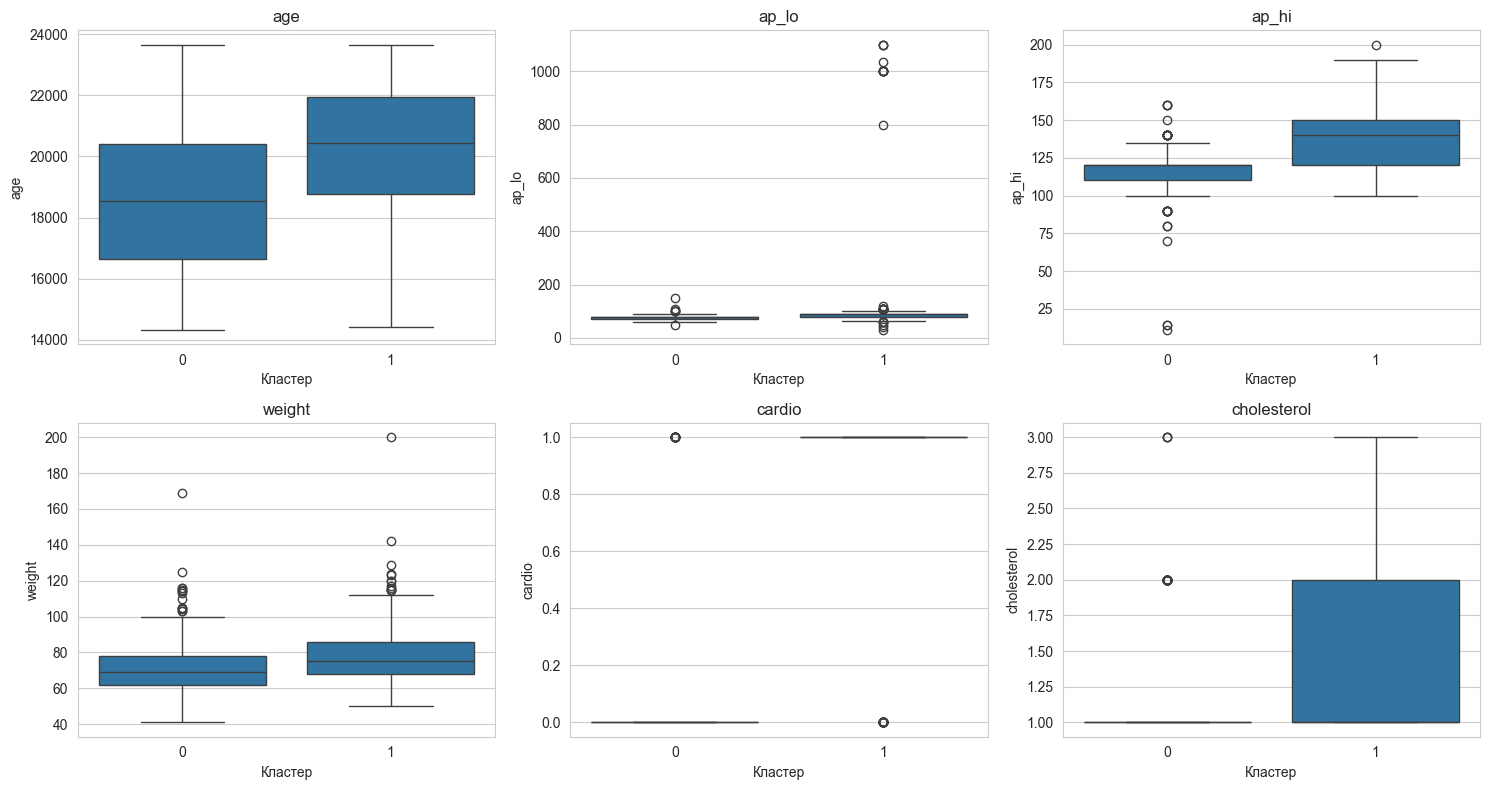

In [69]:
# Сравним средние по признакам между кластерами KMeans (k=2)
clustered = pd.DataFrame(X, columns=feature_cols)
clustered['cluster_km2'] = labels_km2
means = clustered.groupby('cluster_km2')[feature_cols].mean()
print("Средние значения признаков по кластерам (KMeans, k=2):")
print(means)

# Выберем признаки с наибольшими различиями
if len(feature_cols) >= 1:
    diffs = (means.iloc[0] - means.iloc[1]).abs().sort_values(ascending=False)
    top = diffs.head(min(6, len(diffs))).index.tolist()
    print(f"\nТоп признаков по различиям: {top}")
    
    # Определяем размер сетки (2 или 3 столбца в зависимости от количества признаков)
    n_plots = len(top)
    n_cols = 3 if n_plots > 2 else 2
    n_rows = (n_plots + n_cols - 1) // n_cols  # округление вверх
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for i, col in enumerate(top):
        sns.boxplot(data=clustered, x='cluster_km2', y=col, ax=axes[i])
        axes[i].set_xlabel('Кластер')
        axes[i].set_title(col)
    
    # Скрываем лишние subplot'ы если есть
    if top:  # только если есть признаки для отображения
        for j in range(len(top), len(axes)):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


## 6.1 Визуализация кластеров в 2D (PCA)

Отобразим кластеры в 2D-пространстве главных компонент. Для K-Means отметим центры кластеров.

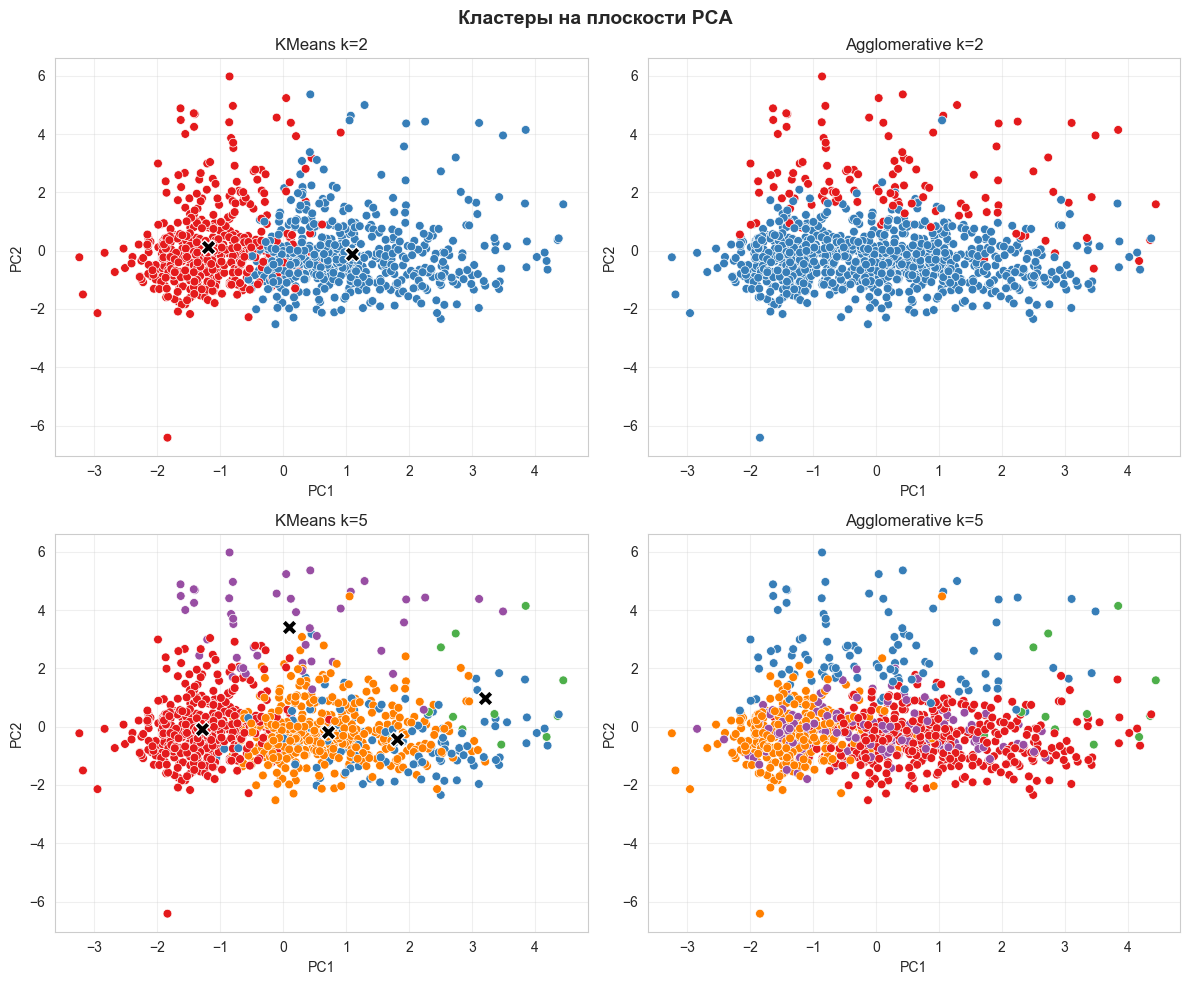

In [70]:
from sklearn.decomposition import PCA

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plots = [
    (labels_km2, 'KMeans k=2'),
    (labels_ag2, 'Agglomerative k=2'),
    (labels_km5, 'KMeans k=5'),
    (labels_ag5, 'Agglomerative k=5'),
]

for ax, (labs, title) in zip(axes, plots):
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labs, palette='Set1', s=40, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

# Отметим центры KMeans на PCA-плоскости
cent2 = pca.transform(kmeans_2.cluster_centers_)
cent5 = pca.transform(kmeans_5.cluster_centers_)

# центры для k=2
axes[0].scatter(cent2[:, 0], cent2[:, 1], c='black', s=120, marker='X', edgecolor='white')
# центры для k=5
axes[2].scatter(cent5[:, 0], cent5[:, 1], c='black', s=120, marker='X', edgecolor='white')

plt.suptitle('Кластеры на плоскости PCA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6.2 Дендрограмма (Agglomerative, Ward)

Построим дендрограмму для иерархической кластеризации (укороченную для читабельности).

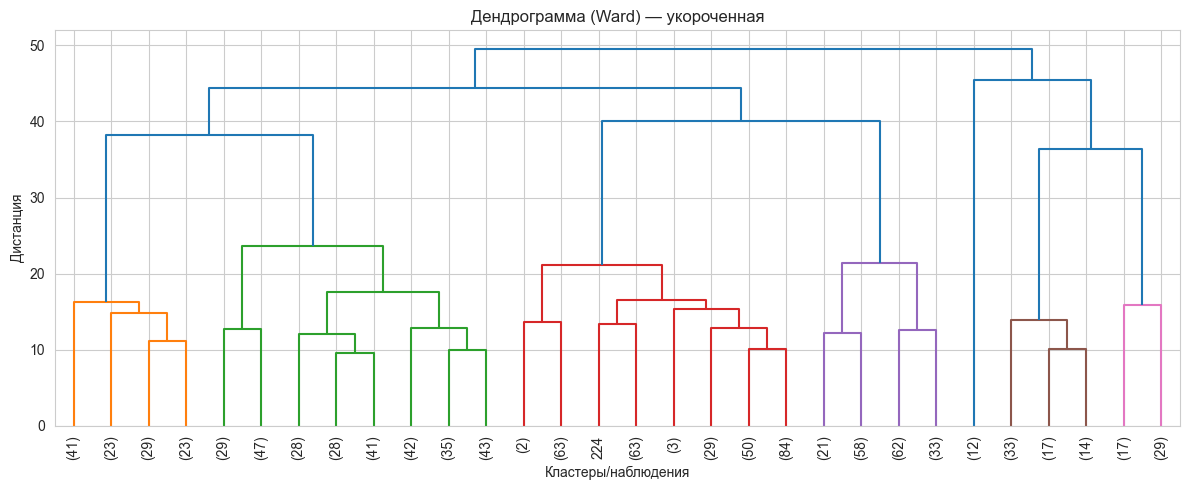

In [71]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10.)
plt.title('Дендрограмма (Ward) — укороченная')
plt.xlabel('Кластеры/наблюдения')
plt.ylabel('Дистанция')
plt.tight_layout()
plt.show()

## 7. Выводы

In [72]:
print("Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):\n")
print(res_df.to_string(index=False))

best_k2 = res_df[res_df['k']==2].sort_values('Silhouette', ascending=False).iloc[0]
best_k5 = res_df[res_df['k']==5].sort_values('Silhouette', ascending=False).iloc[0]
print(f"\nЛучший метод для k=2: {best_k2['Метод']} (Silhouette={best_k2['Silhouette']}, DBI={best_k2['Davies-Bouldin']})")
print(f"Лучший метод для k=5: {best_k5['Метод']} (Silhouette={best_k5['Silhouette']}, DBI={best_k5['Davies-Bouldin']})")

print("\nКомментарий:")
print("- Разметка (gender) не использовалась при обучении, только для интерпретации.")
print("- На 2 кластера ожидаемо выделяются две группы, близкие к классам пола; см. распределения и Purity.")
print("- KMeans обычно быстрее и стабильнее на стандартизованных числовых данных; агломеративный может давать близкое качество.")

Итоговые внутренние метрики (чем выше Silhouette и ниже DBI — тем лучше):

        Метод  k  Silhouette  Davies-Bouldin
       KMeans  2      0.1560          2.2775
       KMeans  5      0.2030          1.4379
Agglomerative  2      0.3438          2.0778
Agglomerative  5      0.1763          1.5793

Лучший метод для k=2: Agglomerative (Silhouette=0.3438, DBI=2.0778)
Лучший метод для k=5: KMeans (Silhouette=0.203, DBI=1.4379)

Комментарий:
- Разметка (gender) не использовалась при обучении, только для интерпретации.
- На 2 кластера ожидаемо выделяются две группы, близкие к классам пола; см. распределения и Purity.
- KMeans обычно быстрее и стабильнее на стандартизованных числовых данных; агломеративный может давать близкое качество.
